# Import Library



1.   Google.Colab => For User Authentication
2.   Pandas => For Importing DataFrame



In [94]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()

# Show Example Data



*   Grouping Number of Basket_ID and Summing Spending for each Customers.
*   Show Example Data with first 5 rows.



In [95]:
project_id = 'nida-crm'
sql ='''
SELECT CUST_CODE,
--SUM(SPEND) AS TOTAL_SALES, 
SUM(QUANTITY) as TOTAL_QTY,
COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT 
FROM `nida-crm.supermarket.supermarket_transaction`
WHERE CUST_CODE IS NOT NULL 
GROUP BY CUST_CODE'''
df = pd.io.gbq.read_gbq(sql , project_id=project_id, verbose=False, dialect="standard")
df.head()

,CUST_CODE,TOTAL_QTY,TOTAL_VISIT
0,CUST0000065412,260,15
1,CUST0000644893,4009,154
2,CUST0000863361,186,32
3,CUST0000543374,553,33
4,CUST0000063931,1938,124


# Show Data Distribution

*   Total Quantities
*   Total Visits



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


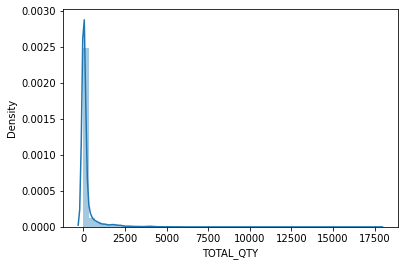

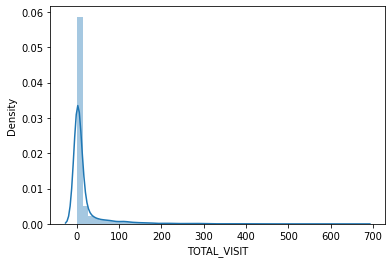

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, col in enumerate(df.columns[1:]):
    plt.figure(i)
    sns.distplot(df[col])
    
plt.show()

# Data Standardization

In [98]:
from sklearn.preprocessing import StandardScaler

df_std = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[1:]]))
df_std.head(5)

,0,1
0,0.103941,-0.098176
1,6.418183,2.615287
2,-0.020693,0.233686
3,0.597426,0.253208
4,2.930108,2.029647


# Show All 1-to-15 Clusters for each KMeans

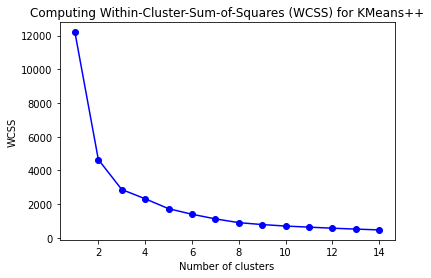

In [99]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_std)
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS) for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# Choose Cluster = 4

In [111]:
#let's choose k = 7
cluster = KMeans(n_clusters=7)
df['cluster'] = cluster.fit_predict(df_std)
df

,CUST_CODE,TOTAL_QTY,TOTAL_VISIT,cluster
0,CUST0000065412,260,15,0
1,CUST0000644893,4009,154,5
2,CUST0000863361,186,32,0
3,CUST0000543374,553,33,2
4,CUST0000063931,1938,124,4
...,...,...,...,...
6095,CUST0000665561,1,1,0
6096,CUST0000951437,3,1,0
6097,CUST0000141967,2,2,0
6098,CUST0000149667,4,2,0


In [112]:
dfCluster = df.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster

,cluster,TOTAL_QTY,TOTAL_VISIT,NO_CUST
0,0,38.516927,5.072651,5258
1,1,1275.607843,209.598039,102
2,2,554.072727,64.868687,495
3,3,3105.678571,438.107143,28
4,4,1812.176101,104.647799,159
5,5,3682.315789,220.298246,57
6,6,17659.000000,554.000000,1


<Figure size 432x288 with 0 Axes>

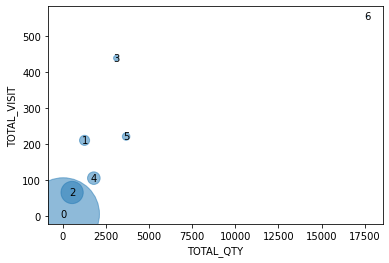

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_QTY'], dfCluster['TOTAL_VISIT'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_QTY")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_QTY'][i], dfCluster["TOTAL_VISIT"][i]), horizontalalignment='center', verticalalignment='center')

plt.show()

# Summary Data within each cluster

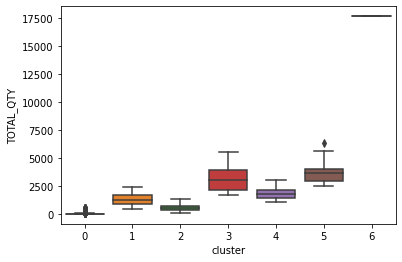

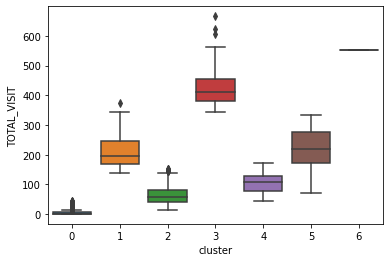

In [114]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

In [115]:
from sklearn.ensemble import RandomForestClassifier

predictors = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Checking Important Features

In [116]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TOTAL_QTY            Importance: 0.54
Variable: TOTAL_VISIT          Importance: 0.46
